# 自己回帰モデル（ARモデル）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

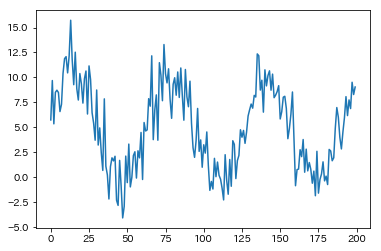

In [2]:
xx = np.arange(200)
xx = 5 * np.sin(0.1 * xx) + 2 * np.random.normal(size=200) + 5.
plt.plot(xx)

## 学習

時系列データが$X=[x_{1}, x_{2}, .., x_{n}]$のとき、ARモデルは直前のデータの重ね合わせ、つまり$x_{s} = w_{0}+ \sum_{j=1}^{m} w_{j} x_{s-j} + \epsilon_{s}$で与えられる。

ただし、$w_{j}$は重みパラメータ、$\epsilon_{s}$は時刻$s$でのノイズであり平均$0$、分散$\sigma^{2}$の正規分布に従うものと仮定する。

このとき$p(x_{s}|x_{s-1}, x_{s-2}, .., x_{s-m}; \boldsymbol{w}, \sigma^{2}) = \mathcal{N}(x_{s} | w_{0}+ \sum_{j=1}^{m} w_{j} x_{s-j}, \sigma^{2})$とかける。パラメータを最尤推定により求める。対数尤度関数は、

\begin{eqnarray}
\log{p(X | \boldsymbol{w}, \sigma^{2})} &=& \prod_{s=1}^{n} p(x_{s} | x_{s-1}, x_{s-2}, .., x_{s-m};\boldsymbol{w}, \sigma^{2}) \\
&=& \sum_{s=1}^{n} [-\frac{1}{2}\log{2 \pi} - \log{\sigma} - \frac{1}{2 \sigma^{2}}(x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j})^{2}]
\end{eqnarray}

となり、ただし、$x_{i}=0 (i \le 0)$とする。各パラメータで偏微分すると、

\begin{eqnarray}
\frac{\partial}{\partial w_{0}} (\log{p(X | \boldsymbol{w}, \sigma^{2})}) &=& \frac{1}{\sigma^{2}} \sum_{s=1}^{n} (x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j}) \\
\frac{\partial}{\partial w_{i}} (\log{p(X | \boldsymbol{w}, \sigma^{2})}) &=& \frac{1}{\sigma^{2}} \sum_{s=1}^{n} (x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j}) x_{s-i} \qquad (i=1, 2, .., m)　\\
\frac{\partial}{\partial \sigma^{2}} (\log{p(X | \boldsymbol{w}, \sigma^{2})}) &=& -\frac{n}{\sigma} + \frac{1}{\sigma^{3}} \sum_{s=1}^{n} (x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j})^{2}
\end{eqnarray}

よって、最尤推定により求まるパラメータは、以下を満たす。

\begin{eqnarray}
&& \hat{w}_{0} = \frac{1}{n} \sum_{s=1}^{n} (x_{s} - \sum_{j=1}^{m} \hat{w}_{j} x_{s-j}) \\
&& \sum_{s=1}^{n}x_{s-i} \sum_{j=1}^{m} \hat{w}_{j} x_{s-j} = \sum_{s=1}^{n} (x_{s} - w_{0}) x_{s-i} \qquad (i=1, 2, .., m) \\
&& \hat{\sigma^{2}} = \frac{1}{n} \sum_{s=1}^{n} (x_{s} - \hat{w}_{0} - \sum_{j=1}^{m} \hat{w}_{j} x_{s-j})^{2}
\end{eqnarray}

$\sum_{s=1}^{n}x_{s-k} x_{s-l} = C(| k-l |)$とすると、$\hat{\boldsymbol{w}}$は以下の方程式の解である。

\begin{eqnarray}
\left( 
\begin{array}{cc}
\hspace{1em} C(0) \hspace{2em} C(1) \hspace{1em} \cdots \hspace{0.3em} C(m-1) \\
\hspace{1em} C(1) \hspace{2em} C(0) \hspace{1em} \cdots \hspace{0.3em} C(m-2) \\
\hspace{0.5em} \vdots \hspace{3em} \vdots \hspace{2em} \ddots \hspace{2em} \vdots \hspace{0.1em} \\
C(m-1) \hspace{0.3em} C(m-2) \hspace{0.1em}\cdots \hspace{0.8em} C(0)
\end{array}
\right)
\left( 
\begin{array}{cc}
\hat{w}_{1} \\
\hat{w}_{2} \\
\vdots \\
\hat{w}_{m}
\end{array}
\right)
&=&
\left( 
\begin{array}{cc}
C(1) - \hat{w}_{0} \sum_{s=1}^{n}x_{s-1} \\
C(2)- \hat{w}_{0} \sum_{s=1}^{n}x_{s-2}\\
\vdots \\
C(m)- \hat{w}_{0} \sum_{s=1}^{n}x_{s-m}
\end{array}
\right) 
\end{eqnarray}

$\hat{w}_{0}$と$\hat{\boldsymbol{w}}$は相互に依存するので、$\hat{w}_{0}$の初期値を0として繰り返し最適化を行う。

In [3]:
x_train = xx
m = 10
n = len(x_train)

# 行列作成
x = np.concatenate([np.zeros(m), x_train])
X = np.array([x[m-i: m-i+n] for i in range(1, m+1)])
x_sum = np.sum(X, axis=1)
A = np.dot(X, X.T)
b = np.dot(X, x_train)

w0 = 0
max_iter = 100
for _ in range(max_iter):
    prev_w0 = w0
    w = np.linalg.solve(A, b - x_sum*w0)
    w0 = np.mean(x_train - np.dot(X.T, w))
    if np.allclose(prev_w0, w0):
        break

std = np.std(x_train - w0 - np.dot(X.T, w))

## 結果

$X=[x_{1}, x_{2}, .., x_{n}]$に対して、$x_{s} = w_{0}+ \sum_{j=1}^{m} w_{j} x_{s-j}$でフィッティングした結果を示し、

予測の際は、予測結果を次の入力として逐次的に求めていく。

In [4]:
# フィッティング結果
y_test = w0 + np.dot(X.T, w)

# 予測
n_step = 10
x_pred = x_train[-m:][::-1]
y_pred = np.zeros(n_step)
for i in range(n_step):
    y_pred[i] = w0 + np.dot(w, x_pred)
    x_pred = np.concatenate([[y_pred[-1]], x_pred[:-1]])

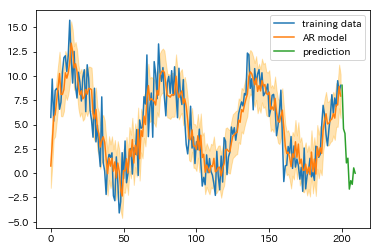

In [5]:
plt.plot(x_train, label='training data')
plt.plot(y_test, label='AR model')
plt.fill_between(np.arange(n), y_test-std, y_test+std, color='orange', alpha=0.3)
plt.plot(np.arange(n, n+n_step), y_pred, label='prediction')
plt.legend()